「仕事ではじめる機械学習」第９章の Uplift Modeling を追実装する。


Uplift Modelingは、ランダム化比較試験、いわゆるA/Bテストの結果を用いて、分析を行い、

どのようなセグメントに介入の効果があったのかを理解するための手法。


便宜的に、ある行動をCV（コンバージョン）とし、

介入する・しない、CVする・しないで以下のような、４象限のセグメントが想定される。


|   	|介入する|介入しない|
|:-:	|:-:	|:-:	|
|CVする|説得可能|鉄板|
|CVしない|天邪鬼|無関心|


- 無関心：介入をしてもCVしない群。介入コストが高いことが推測される
- 説得可能：介入することでCVする群。介入する効果が高いことが推測される
- 天邪鬼：なにもしないことでCVする群。介入を行ってはいけない
- 鉄板：介入してもしなくてもCVする群。CVに対する熱量が高いことが推測される


まずは、データジェネレーターを生成。

In [24]:
import random

def generate_sample_data(num, seed=1):
    # 返す値を用意
    is_cv_list = []
    is_treat_list = []
    feature_vector_list = []
    
    random_instance = random.Random(seed)
    
    feature_num = 8
    base_weight = [0.02, 0.03, 0.05, -0.04, 0.00, 0.00, 0.00, 0.00]
    lift_weight = [0.00, 0.00, 0.00, 0.05, -0.05, 0.00, 0.00, 0.00]
    
    for i in range(num):
        feature_vector = [random_instance.random() for n in range(feature_num)]
        is_treat = random_instance.choice((True, False))
        cv_rate = sum([feature_vector[n] * base_weight[n] for n in range(feature_num)])
        
        if is_treat:
            # Treat群の場合、介入効果を加算
            cv_rate += sum([feature_vector[n] * lift_weight[n] for n in range(feature_num)])
            
        is_cv = cv_rate > random_instance.random()
        
        is_cv_list.append(is_cv)
        is_treat_list.append(is_treat)
        feature_vector_list.append(feature_vector)
        
    return is_cv_list, is_treat_list, feature_vector_list

In [25]:
generate_sample_data(2)

([False, False],
 [True, True],
 [[0.13436424411240122,
   0.8474337369372327,
   0.763774618976614,
   0.2550690257394217,
   0.49543508709194095,
   0.4494910647887381,
   0.651592972722763,
   0.7887233511355132],
  [0.8933170425576351,
   0.3898088070211341,
   0.6074379962852603,
   0.767157629147962,
   0.6958328667684435,
   0.26633056045725956,
   0.8018263669964836,
   0.5911534350013039]])

原始的なUplift Modelingでは、コンバージョンレートを予測するモデルを統制群・実験群の２つ作る。

- 統制群：介入行為を行わなかったときのコンバージョンレートを予測
- 実験群：介入行為を行ったときのコンバージョンレートを予測

２つのモデルを組み合わせることで、介入行為によるコンバージョンレートの変化を予測できるようになる。

実際にデータを生成し、試してみる。

In [28]:
sample_num = 100000
train_is_cv_list, train_is_treat_list, train_feature_vector_list = generate_sample_data(sample_num, seed=1)

treat_is_cv_list = []
treat_feature_vector_list = []
control_is_cv_list = []
control_feature_vector_list = []

for i in range(sample_num):
    if train_is_treat_list[i]:
        treat_is_cv_list.append(train_is_cv_list[i])
        treat_feature_vector_list.append(train_feature_vector_list[i])
    else:
        control_is_cv_list.append(train_is_cv_list[i])
        control_feature_vector_list.append(train_feature_vector_list[i])


print('treatment_cvr', treat_is_cv_list.count(True)/len(treat_is_cv_list))
print('control_cvr', control_is_cv_list.count(True)/len(control_is_cv_list))

treatment_cvr 0.031220247540463344
control_cvr 0.031905453372055505


ここでは、実験群・統制群でCVRにほとんど差がない。

これがA/Bテストであったなら、差がないためこの実験は失敗であった、という判断になる。
  
しかし、Uplift Modelingでは、顧客のもつ特徴量とコンバージョンの有無を元に、

どのようなセグメントが介入行為に反応したのか、または、反応しなかったのかを分析する。

介入行為により、改善するセグメントを特定するため、実験群・統制群でコンバージョンを予測するモデルを作る。

アルゴリズムは、ロジスティック回帰を用いる。

In [82]:
from sklearn.linear_model import LogisticRegression

treat_model = LogisticRegression(C=0.01)
control_model = LogisticRegression(C=0.01)


treat_model.fit(treat_feature_vector_list, treat_is_cv_list)
control_model.fit(control_feature_vector_list, control_is_cv_list)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

２つのモデルを用いる場合、実験群の予測値と統制群の予測値の２つが得られる。

２つの値を用いて、説得可能な顧客と天邪鬼な顧客に分類するため、`UpliftModeligのスコア`を定義する。

- 説得可能な顧客：統制群の予測値が低く、実験群の予測値が高い
- 天邪鬼な顧客：統制群の予測値が高く、実験群の予測値が低い



$
    UpliftModelig のスコア = \frac{実験群の予測値}{統制群の予測値}
$


memo:

UpliftModelingスコアは、介入をすることでCVするスコア。とも言える。

確率の割合になっていてかなりややこしい。


In [83]:
sample_num = 100000
test_is_cv_list, test_is_treat_list, test_feature_vector_list = generate_sample_data(sample_num, seed=42)

treat_score = treat_model.predict_proba(test_feature_vector_list)
control_score = control_model.predict_proba(test_feature_vector_list)

score_list = treat_score[:, 1] / control_score[:, 1]

これにより、ある顧客が介入行為によりCVに転じるかどうかの指標ができた。

スコアが大きい順に10パーセンタイルごとにソートし、比較をする。

Uplift Medelingが正しく機能していれば、

スコアが高いほど統制群のコンバージョンレートが低く、実験群のコンバージョンレートが高い。

また、スコアが低いほど、その逆の傾向になっているはず。

Text(0, 0.5, 'conversion rate')

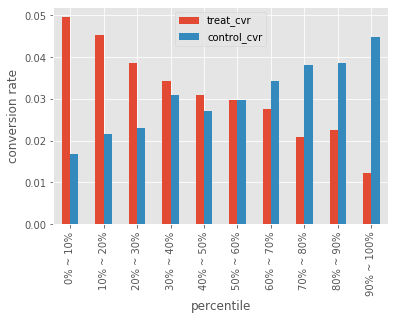

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter
plt.style.use('ggplot')
%matplotlib inline

result = list(zip(test_is_cv_list, test_is_treat_list, score_list))
result.sort(key=itemgetter(2), reverse=True)

qdf = pd.DataFrame(columns=('treat_cvr', 'control_cvr'))

for n in range(10):
    # 結果を10パーセンタイルに切断
    start = int(n * len(result) / 10)
    end = int((n + 1) * len(result) / 10) - 1
    quantiled_result = result[start:end]
    
    treat_uu = list(map(lambda item: item[1], quantiled_result)).count(True)
    control_uu = list(map(lambda item: item[1], quantiled_result)).count(False)
    
    treat_cv = [item[0] for item in quantiled_result if item[1] is True].count(True)
    control_cv = [item[0] for item in quantiled_result if item[1] is False].count(True)
    
    treat_cvr = treat_cv / treat_uu
    control_cvr = control_cv / control_uu
    
    label = f'{n*10}% ~ {(n+1)*10}%'
    qdf.loc[label] = [treat_cvr, control_cvr]
    
qdf.plot.bar()
plt.xlabel('percentile')
plt.ylabel('conversion rate')

スコアが高いほど実験群のコンバージョンレートが高く、統制群のコンバージョンレートが低いことがわかる。

このグラフからは、スコアの上位50％にだけ介入行為を行えば全体のコンバージョンレートが上がることがわかる。

次に、Uplift Modelingの評価を行う。

評価値には、`Area Under the Uplift Curve` (AUUC) を用いる。

AUUCが大きければ大きほど、Uplift Modelingの性能が高いといえる。

AUUCの算出には、liftという指標を用いる。

liftは、あるスコア以上の顧客に介入行為を行い、あるスコア未満の顧客には介入行為を行わなかった場合、介入行為を行わなかった場合とを比較してどのくらいコンバージョン数が増えたのか、という値。


AUUCの算出には以下の手順が必要

1. スコアの高い順に走査し、その時点までのコンバージョンレートを計測する
1. コンバージョンレートの差から、介入行為によるコンバージョン上昇数（lift）を算出する
1. ランダムに介入を行った場合の想定コンバージョン上昇数として、liftの原点と終点を結んだ直線をベースライン(base_line)とする
1. liftとbase_lineに囲まれた領域の面積を算出し、正規化し、AUUCとする

Text(0, 0.5, 'conversion lift')

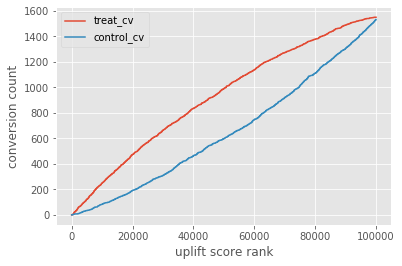

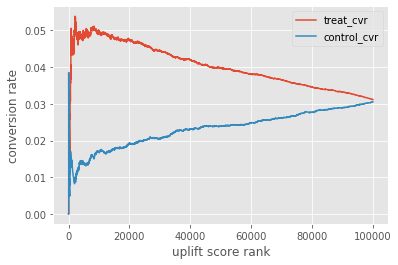

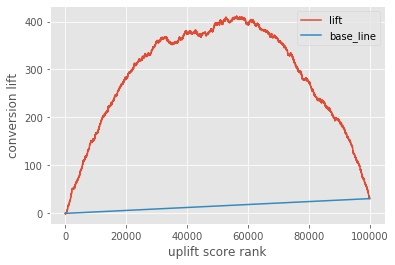

In [85]:
treat_uu = 0
control_uu = 0
treat_cv = 0
control_cv = 0
treat_cvr = 0.0
control_cvr = 0.0
lift = 0.0

stat_data = []

for is_cv, is_treat, score in result:
    if is_treat:
        treat_uu += 1
        if is_cv:
            treat_cv += 1
        treat_cvr = treat_cv / treat_uu
    else:
        control_uu += 1
        if is_cv:
            control_cv += 1
        control_cvr = control_cv / control_uu
    
    # 介入を行ったことでコンバージョンした数
    lift = (treat_cvr - control_cvr) * treat_uu
    
    stat_data.append([is_cv, is_treat, score, treat_uu, control_uu, 
                      treat_cv, control_cv, treat_cvr, control_cvr, lift])

df = pd.DataFrame(stat_data)
df.columns = ['is_cv', 'is_treat', 'score', 'treat_uu', 'control_uu', 
              'treat_cv', 'control_cv', 'treat_cvr', 'control_cvr', 'lift']

# ランダムに介入を行った場合のコンバージョン数
df['base_line'] = df.index * df['lift'][len(df.index) - 1] / len(df.index)

df.plot(y=['treat_cv', 'control_cv'])
plt.xlabel('uplift score rank')
plt.ylabel('conversion count')

df.plot(y=['treat_cvr', 'control_cvr'])
plt.xlabel('uplift score rank')
plt.ylabel('conversion rate')

df.plot(y=['lift', 'base_line'])
plt.xlabel('uplift score rank')
plt.ylabel('conversion lift')

In [86]:
auuc = (df['lift'] - df['base_line']).sum() / len(df['lift'])
print('AUUC:', auuc)

AUUC: 267.2627260920977


Uplift Modelingの精度が高いほど、スコアの上位は実験群においてコンバージョンする顧客が集まり、統制群においてはコンバージョンしない顧客が集まる。

実運用をする際は、スコアに従って介入行為を実施するか否か決断する必要がある。

そのため、どのスコア以上で介入行為を行うかどうかを決定するために、横軸をスコアにしたものを可視化する。

Text(0, 0.5, 'conversion lift')

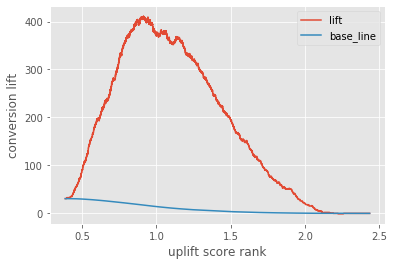

In [88]:
df.plot(x='score', y=['lift', 'base_line'])
plt.xlabel('uplift score rank')
plt.ylabel('conversion lift')

最後に、実データを使ってUplift Modelingを試す。

データは、The MineThatData E-Mail Analytics And Data Mining Challengeのデータセットを利用する。

このデータは、過去１２ヶ月に購買履歴のある顧客に対して、「ランダムに男性向けメール」「女性向けメール」「メールを送らない」の３種類の介入を実施し、その後のサイト訪問に結びついたか、商品を買ったかなどを調べたもの。

In [92]:
import urllib.request

csv_url = "http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv"
csv_filename = "source_data.csv"

with open(csv_filename, "w") as fp:
    data = urllib.request.urlopen(csv_url).read()
    fp.write(data.decode("ascii"))
    
source_df = pd.read_csv(csv_filename)
source_df.head(10)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0
5,6,2) $100 - $200,134.83,0,1,Surburban,0,Phone,Womens E-Mail,1,0,0.0
6,9,3) $200 - $350,280.20,1,0,Surburban,1,Phone,Womens E-Mail,0,0,0.0
7,9,1) $0 - $100,46.42,0,1,Urban,0,Phone,Womens E-Mail,0,0,0.0
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0
9,10,1) $0 - $100,32.84,0,1,Urban,1,Web,Womens E-Mail,0,0,0.0


In [96]:
# 今回は「卵生向けのメールを送るか、女性向けのメールを送るか」という問題として扱うため、「メールを送らない」という実験データを捨てる

mailed_df = source_df[source_df['segment']!='No E-Mail']
mailed_df = mailed_df.reset_index(drop=True)
mailed_df.head(10)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
2,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
3,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0
4,6,2) $100 - $200,134.83,0,1,Surburban,0,Phone,Womens E-Mail,1,0,0.0
5,9,3) $200 - $350,280.20,1,0,Surburban,1,Phone,Womens E-Mail,0,0,0.0
6,9,1) $0 - $100,46.42,0,1,Urban,0,Phone,Womens E-Mail,0,0,0.0
7,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0
8,10,1) $0 - $100,32.84,0,1,Urban,1,Web,Womens E-Mail,0,0,0.0
9,7,5) $500 - $750,548.91,0,1,Urban,1,Phone,Womens E-Mail,1,0,0.0


In [115]:
dummied_df = pd.get_dummies(mailed_df[['history_segment', 'zip_code', 'channel']], drop_first=True)
feature_vector_df = mailed_df.drop(['history_segment', 'history', 'zip_code', 'channel',
                                   'segment', 'visit', 'conversion', 'spend'], axis=1)

feature_vector_df = feature_vector_df.join(dummied_df)
feature_vector_df.head(10)

,recency,mens,womens,newbie,history_segment_2) $100 - $200,history_segment_3) $200 - $350,history_segment_4) $350 - $500,history_segment_5) $500 - $750,"history_segment_6) $750 - $1,000","history_segment_7) $1,000 +",zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
0,10,1,0,0,1,0,0,0,0,0,1,0,1,0
1,7,0,1,1,1,0,0,0,0,0,1,0,0,1
2,9,1,0,1,0,0,0,1,0,0,0,0,0,1
3,2,1,0,0,0,0,0,0,0,0,0,1,0,1
4,6,0,1,0,1,0,0,0,0,0,1,0,1,0
5,9,1,0,1,0,1,0,0,0,0,1,0,1,0
6,9,0,1,0,0,0,0,0,0,0,0,1,1,0
7,9,1,1,1,0,0,0,1,0,0,0,0,1,0
8,10,0,1,1,0,0,0,0,0,0,0,1,0,1
9,7,0,1,1,0,0,0,1,0,0,0,1,1,0


男性向けメールをTreatとしてフラグを付け、サイト訪問をコンバージョンとしてフラグを付ける。

In [116]:
is_treat_list = list(mailed_df['segment'] == "Mens E-Mail")
is_cv_list = list(mailed_df['visit'] == 1)

In [117]:
from sklearn.model_selection import train_test_split

train_is_cv_list, test_is_cv_list, train_is_treat_list, test_is_treat_list, \
train_feature_vector_df, test_feature_vector_df = train_test_split(
    is_cv_list, is_treat_list, feature_vector_df, test_size=0.5, random_state=42)


train_feature_vector_df = train_feature_vector_df.reset_index(drop=True)
test_feature_vector_df = test_feature_vector_df.reset_index(drop=True)

実験群と統制群の学習機をつくり、学習を行う。

In [118]:
train_sample_num = len(train_is_cv_list)

treat_is_cv_list = []
treat_feature_vector_list = []
control_is_cv_list = []
control_feature_vector_list = []

for i in range(train_sample_num):
    if train_is_treat_list[i]:
        treat_is_cv_list.append(train_is_cv_list[i])
        treat_feature_vector_list.append(train_feature_vector_df.iloc[i])
    else:
        control_is_cv_list.append(test_is_cv_list[i])
        control_feature_vector_list.append(test_feature_vector_df.iloc[i])
        
from sklearn.linear_model import LogisticRegression

treat_model = LogisticRegression(C=0.01)
control_model = LogisticRegression(C=0.01)

treat_model.fit(treat_feature_vector_list, treat_is_cv_list)
control_model.fit(control_feature_vector_list, control_is_cv_list)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Text(0, 0.5, 'conversion rate')

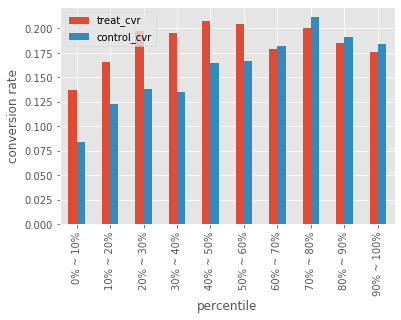

In [122]:
treat_score = treat_model.predict_proba(test_feature_vector_df)
control_score = control_model.predict_proba(test_feature_vector_df)

score_list = treat_score[:, 1] / control_score[:, 1]

import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter
plt.style.use('ggplot')
%matplotlib inline

result = list(zip(test_is_cv_list, test_is_treat_list, score_list))
result.sort(key=itemgetter(2), reverse=True)

qdf = pd.DataFrame(columns=('treat_cvr', 'control_cvr'))

for n in range(10):
    # 結果を10パーセンタイルに切断
    start = int(n * len(result) / 10)
    end = int((n + 1) * len(result) / 10) - 1
    quantiled_result = result[start:end]
    
    treat_uu = list(map(lambda item: item[1], quantiled_result)).count(True)
    control_uu = list(map(lambda item: item[1], quantiled_result)).count(False)
    
    treat_cv = [item[0] for item in quantiled_result if item[1] is True].count(True)
    control_cv = [item[0] for item in quantiled_result if item[1] is False].count(True)
    
    treat_cvr = treat_cv / treat_uu
    control_cvr = control_cv / control_uu
    
    label = f'{n*10}% ~ {(n+1)*10}%'
    qdf.loc[label] = [treat_cvr, control_cvr]
    
qdf.plot.bar()
plt.xlabel('percentile')
plt.ylabel('conversion rate')

Text(0, 0.5, 'conversion lift')

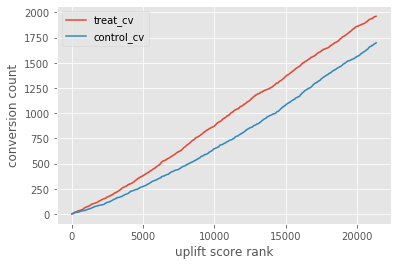

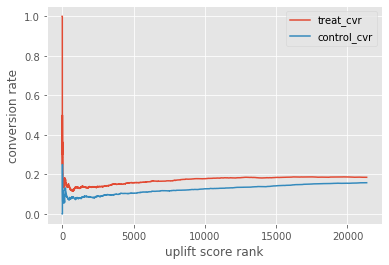

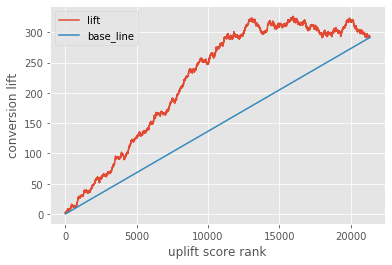

In [123]:
treat_uu = 0
control_uu = 0
treat_cv = 0
control_cv = 0
treat_cvr = 0.0
control_cvr = 0.0
lift = 0.0

stat_data = []

for is_cv, is_treat, score in result:
    if is_treat:
        treat_uu += 1
        if is_cv:
            treat_cv += 1
        treat_cvr = treat_cv / treat_uu
    else:
        control_uu += 1
        if is_cv:
            control_cv += 1
        control_cvr = control_cv / control_uu
    
    # 介入を行ったことでコンバージョンした数
    lift = (treat_cvr - control_cvr) * treat_uu
    
    stat_data.append([is_cv, is_treat, score, treat_uu, control_uu, 
                      treat_cv, control_cv, treat_cvr, control_cvr, lift])

df = pd.DataFrame(stat_data)
df.columns = ['is_cv', 'is_treat', 'score', 'treat_uu', 'control_uu', 
              'treat_cv', 'control_cv', 'treat_cvr', 'control_cvr', 'lift']

# ランダムに介入を行った場合のコンバージョン数
df['base_line'] = df.index * df['lift'][len(df.index) - 1] / len(df.index)

df.plot(y=['treat_cv', 'control_cv'])
plt.xlabel('uplift score rank')
plt.ylabel('conversion count')

df.plot(y=['treat_cvr', 'control_cvr'])
plt.xlabel('uplift score rank')
plt.ylabel('conversion rate')

df.plot(y=['lift', 'base_line'])
plt.xlabel('uplift score rank')
plt.ylabel('conversion lift')